In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda, Concatenate, Reshape, Add
from keras.layers.merge import Multiply
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Model
from keras.models import load_model
from keras.models import model_from_json
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
def open_and_load(string):
    with open('trained/'+string+'.json', 'r') as f:
        model = model_from_json(f.read())
    model.load_weights('trained/'+string+'.h5')   
    return model

Using TensorFlow backend.


In [49]:
change2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [8]:
def save_model(model, model_str):
    model_json = model.to_json()
    with open('trained/'+model_str+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('trained/'+model_str+".h5")
    print("Saved model to disk")

In [9]:
change2 = open_and_load('change') #is pos or neg, 1 arg
border = open_and_load('border') #which border, b1,b2,x
border_att = open_and_load('border_att') #isFirstBorder, b1,b2,bx
att = open_and_load('att3') #move or bounce, x,v,b
move = open_and_load('move') # x+v, x,v,b
bounce = open_and_load('bounce') #2b-v-x, x,v,b

In [4]:
def gen(batch_size=128):
    while True:
        a = np.zeros((batch_size,4)) #x, v, b1, b2
        a[:,1] = np.random.uniform(0,0.1,size=batch_size)
        a[:,2] = np.random.uniform(0,-10,size=batch_size)
        a[:,3] = np.random.uniform(0, 10,size=batch_size)
        i = np.random.choice([0,1], size=batch_size) #isb1
        b = a[:,2]*i + a[:,3]*(1-i)
        a[:,1] *= np.sign(1-i-0.5) 
        a[:,0] = np.random.uniform(b, b-2*a[:,1])
        
        isBounce = ( np.abs(a[:,0] + a[:,1]) - np.abs(b)) > 0
        
        v = a[:,1] * np.sign(1-isBounce-0.5) #new speed
        x = (a[:,0] + a[:,1]) * (1-isBounce) + (2*b-a[:,1]-a[:,0])*isBounce
        b_newIsb1 = ((x-a[:,2])/(a[:,3]-a[:,2])) < 0.5
        b_new = a[:,2]*b_newIsb1 + a[:,3]*(1-b_newIsb1)
        y = np.zeros((batch_size,2))
        y[:,0] = x
        y[:,1] = v
#         y[:,2] = b_new
        
#         y = np.zeros((batch_size,3))
#         y[:,0] = x
#         y[:,1] = v
#         y[:,2] = b_new
        
        yield a, y     

In [11]:
a,b = next(gen(batch_size=1))

In [12]:
a = np.random.randn(4)
b = np.random.randn(4)

In [13]:
K.np.concatenate([a.tolist(),b.tolist()])

array([-0.45111251, -1.32931188, -0.05351418,  0.15092889, -0.35232   ,
       -0.72421169,  0.72931392, -0.83640952])

In [43]:
i = Input(shape=(4,))

x = Lambda(lambda s: s[:,0],name='x')(i)
v = Lambda(lambda s: s[:,1],name='v')(i)
b1 = Lambda(lambda s: s[:,2],name='b1')(i)
b2 = Lambda(lambda s: s[:,3],name='b2')(i)
dropv = Lambda(lambda s: K.stack([s[0],s[1],s[2]], axis=1), output_shape=(3,),name='drop_v')([b1,b2,x])
# dropv = Concatenate(axis=1)([b1,b2])
# dropv = Reshape((3,))(dropv)
border.name='border'
getb = border(dropv)
getb = Reshape((1,))(getb)

xv = Lambda(lambda s: K.stack([s[0],s[1]], axis=1), output_shape=(2,),name='xv')([x,v])
# xv = Reshape((2,))(xv)
xvb = Concatenate(name='xvb')([xv,getb])
att.name='attention'
at = att(xvb)
# at3 = Lambda(lambda s: K.stack([s[:,0],s[:,0],s[:,0]],axis=1))(at)
bounce.name='bounce'
h3 = bounce(xvb)
v2 = Lambda(lambda s: -s, output_shape=(1,),name='new_v')(v)
h3 = Concatenate(name='bounce_concat')([h3,Reshape((1,))(v2)])
mul1 = Multiply(name='mul_att_bounce')([h3, at])

notat = Lambda(lambda s: 1-s, output_shape=(1,),name='1-att')(at)
# notat3 = Lambda(lambda s: K.stack([1-s[:,0],1-s[:,0],1-s[:,0]],axis=1))(at)
move.name='move'
g3 = move(xvb)
g3 = Concatenate(name='move_concat')([g3,Reshape((1,))(v)])
mul2 = Multiply(name='mul_att_move')([g3, notat])

out = Add(name='output')([mul1,mul2])

module = Model(inputs=i, outputs=out)
module.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
module.get_layer('model_32').name='attention'

In [44]:
module.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
x (Lambda)                      (None,)              0           input_11[0][0]                   
__________________________________________________________________________________________________
b1 (Lambda)                     (None,)              0           input_11[0][0]                   
__________________________________________________________________________________________________
b2 (Lambda)                     (None,)              0           input_11[0][0]                   
__________________________________________________________________________________________________
drop_v (La

In [9]:
a, y = next(gen(batch_size=1))
P = module.predict(a)

In [10]:
mse(y, P)

8.175270523099913e-13

In [39]:
module.name='module'

In [40]:
inputs2d = Input(shape=(8,))

split_x = Lambda(lambda s: s[:,:4], output_shape=(4,),name='x')(inputs2d)
split_x = Reshape((4,))(split_x) #split_x.shape gives (None, 4) otherwise
model_x = module(split_x)

split_y = Lambda(lambda s: s[:,4:], output_shape=(4,1),name='y')(inputs2d)
split_y = Reshape((4,))(split_y)
model_y = module(split_y)

x = Concatenate()([model_x, model_y])

model_2d = Model(inputs=inputs2d, outputs=x)
model_2d.compile(loss=mean_squared_error,
              optimizer='adam')

In [34]:
model_2d.get_layer(name='model_3').name='module'

In [45]:
from keras.utils import plot_model
plot_model(module, to_file='module.png')

In [41]:
model_2d.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
x (Lambda)                      (None, 4)            0           input_10[0][0]                   
__________________________________________________________________________________________________
y (Lambda)                      (None, 4, 1)         0           input_10[0][0]                   
__________________________________________________________________________________________________
reshape_17 (Reshape)            (None, 4)            0           x[0][0]                          
__________________________________________________________________________________________________
reshape_18

In [13]:
module.fit_generator(gen(), steps_per_epoch=12800, epochs=10)

Epoch 1/10
12800/12800 [==============================] - 38s 3ms/step - loss: 1.9319e-04 - acc: 0.9993
Epoch 2/10
12800/12800 [==============================] - 38s 3ms/step - loss: 2.0211e-04 - acc: 0.9989
Epoch 3/10
12800/12800 [==============================] - 38s 3ms/step - loss: 1.8735e-04 - acc: 0.9993
Epoch 4/10
12800/12800 [==============================] - 38s 3ms/step - loss: 1.7901e-04 - acc: 0.9992
Epoch 5/10
12800/12800 [==============================] - 38s 3ms/step - loss: 1.8615e-04 - acc: 0.9992
Epoch 6/10
12800/12800 [==============================] - 38s 3ms/step - loss: 1.7166e-04 - acc: 0.9993
Epoch 7/10
12800/12800 [==============================] - 38s 3ms/step - loss: 1.7731e-04 - acc: 0.9989
Epoch 8/10
12800/12800 [==============================] - 38s 3ms/step - loss: 1.6494e-04 - acc: 0.9992
Epoch 9/10
12800/12800 [==============================] - 38s 3ms/step - loss: 1.7764e-04 - acc: 0.9992
Epoch 10/10
12800/12800 [==============================] - 38s 3

In [2]:
# module = open_and_load('module')
model_2d = open_and_load('model_2d')

In [5]:
X, Y = next(gen(batch_size=1000))
X2, Y2 = next(gen(batch_size=1000))
A = np.concatenate([X,X2], axis=-1)
P = model_2d.predict(A)
B = np.concatenate([Y,Y2], axis=-1)

In [6]:
mse(P,B)**0.5

0.012564924414722508

In [7]:
model_2d.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
lambda_152 (Lambda)             (None, 4)            0           input_25[0][0]                   
__________________________________________________________________________________________________
lambda_153 (Lambda)             (None, 4, 1)         0           input_25[0][0]                   
__________________________________________________________________________________________________
reshape_40 (Reshape)            (None, 4)            0           lambda_152[0][0]                 
__________________________________________________________________________________________________
reshape_41

In [8]:
module.summary()

NameError: name 'module' is not defined

###### Plotting

In [17]:
X, Y = next(gen(batch_size=1))
X2, Y2 = next(gen(batch_size=1))
# P = module.predict(a)

b1, b2 = X[0,2:]
c1, c2 = X2[0,2:]

X

A = np.concatenate([X,X2], axis=-1)

preds = []
# preds += [P]
# x, xv, y, yv = P
newA = A
for _ in range(25):
    P = model_2d.predict(newA)
    preds += [P[0]]
    x, xv, y, yv = P[0]
    newA = np.array([[x,xv, b1, b2, y, yv, c1, c2]])

In [18]:
preds = np.array(preds)

In [19]:
import pandas as pd

In [20]:
b1,b2,c1,c2

(-7.127292926784622,
 8.818742954867599,
 -3.4936525313243894,
 2.5513791681016906)

In [21]:
pd.DataFrame(preds)

,0,1,2,3
0,-7.126631,-0.060007,-3.436925,-0.059717
1,-7.067962,0.060007,-3.492882,0.015227
2,-7.007980,0.060007,-3.477634,0.015227
3,-6.948055,0.060007,-3.462401,0.015227
4,-6.888187,0.060007,-3.447183,0.015227
5,-6.828377,0.060007,-3.431979,0.015227
6,-6.768624,0.060007,-3.416790,0.015227
7,-6.708929,0.060007,-3.401615,0.015227
8,-6.649290,0.060007,-3.386455,0.015227
9,-6.589709,0.060007,-3.371310,0.015227


In [28]:
m1,n1 = preds[0,[0,2]]

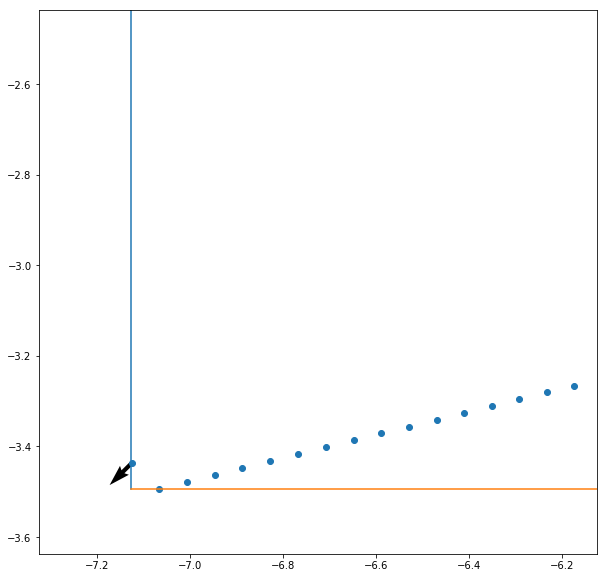

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(m1-0.2, m1+1), ylim=(n1-0.2,n1+1))

x,xv,y,yv = preds[0]
plt.quiver(x, y, xv, yv)
plt.scatter(preds[:,0], preds[:,2])
plt.plot([b1,b1],[c1,c2])
plt.plot([b1,b2],[c1,c1])

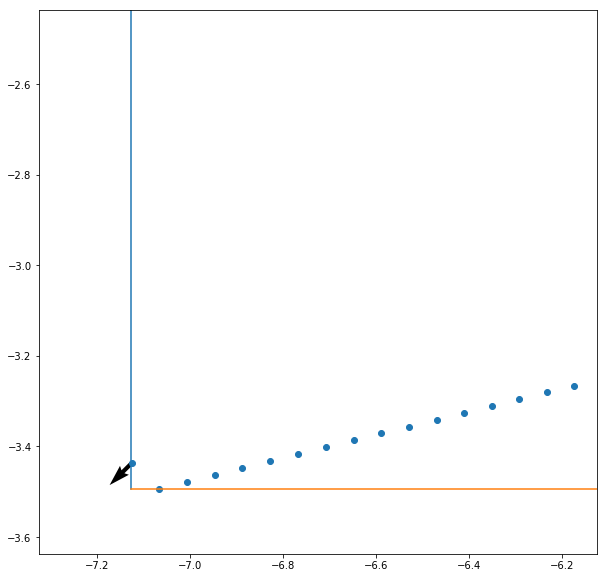

In [35]:
fig.sa

In [23]:
# save_model(module, 'module')
# save_model(model_2d, 'model_2d')

In [28]:
preds

array([[-1.4636651e+00, -6.8700299e-02, -6.2146912e+00, -9.4173307e-04],
       [-1.4999590e+00,  6.8700299e-02, -6.2155461e+00, -7.8382174e-04],
       [-1.4312897e+00,  6.8700299e-02, -6.2159448e+00, -5.0023623e-04],
       [-1.3626862e+00,  6.8700299e-02, -6.2159843e+00, -3.0310723e-04],
       [-1.2941483e+00,  6.8700299e-02, -6.2159276e+00, -1.9690198e-04],
       [-1.2256762e+00,  6.8700299e-02, -6.2158542e+00, -1.3681198e-04],
       [-1.1572696e+00,  6.8700299e-02, -6.2157841e+00, -1.0013520e-04],
       [-1.0889285e+00,  6.8700299e-02, -6.2157207e+00, -7.6269105e-05],
       [-1.0206529e+00,  6.8700299e-02, -6.2156639e+00, -5.9937280e-05],
       [-9.5244271e-01,  6.8700299e-02, -6.2156129e+00, -4.8318805e-05],
       [-8.8429785e-01,  6.8700299e-02, -6.2155666e+00, -3.9794475e-05],
       [-2.2163544e+00, -6.8700299e-02, -6.2155247e+00, -3.3380049e-05],
       [-7.4770141e-01,  6.8700299e-02, -6.2154860e+00, -2.8452132e-05],
       [-2.3528724e+00, -6.8700299e-02, -6.2154508e

## Loss landscape

In [29]:
from copy import deepcopy

In [31]:
# ogweights = model_2d.get_weights()

In [32]:
np.random.randn(3, 2)

array([[-1.53642525,  0.67113638],
       [-1.00822029, -2.41739265],
       [ 0.22400109,  0.35482583]])

In [33]:
X, Y = next(gen(batch_size=1000))
X2, Y2 = next(gen(batch_size=1000))
A = np.concatenate([X,X2], axis=-1)
P = model_2d.predict(A)
B = np.concatenate([Y,Y2], axis=-1)

In [34]:
B.shape

(1000, 4)

In [35]:
np.random.normal(size=(3,2))

array([[ 1.43661767, -1.0871393 ],
       [ 1.52705367,  0.91948453],
       [-0.72657769,  0.32978971]])

In [36]:
# og_weights = deepcopy(model_2d.get_weights())

In [37]:
# delta = deepcopy(model_2d.get_weights())

# theta = []
# for weights in delta:
#     theta += [np.random.normal(scale=0.9, size=weights.shape) * weights]
    
# def get_weight_combo(alpha):
#     l = []
#     if alpha > 1:
        
        
        
#     for i in range(len(delta)):
#         l += [ delta[i]*alpha + theta[i]*(1-alpha) ]
#     return l

In [39]:
model_2d.set_weights(ogweights)

In [40]:
delta = deepcopy(model_2d.get_weights())

theta = []
for weights in delta:
    theta += [np.random.normal(scale=0.5, size=weights.shape) * weights]
    
def get_weight_combo(alpha):
    l = []
    for i in range(len(delta)):
        l += [ delta[i]*alpha + theta[i]*(1-alpha) ]
    return l

In [41]:
rmse_list = []
alphas = np.linspace(0, 2, num=101)
for alpha in alphas:
    weights = get_weight_combo(alpha)
    model_2d.set_weights(weights)
    P = model_2d.predict(A)
    rmse_list += [mse(B, P)**0.5]

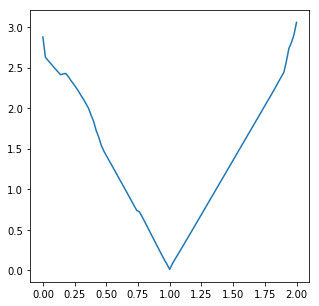

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
# ax.set(xlim=(0, 2))
# line = ax.plot([0,1],[0,0])

plt.plot(alphas, rmse_list)

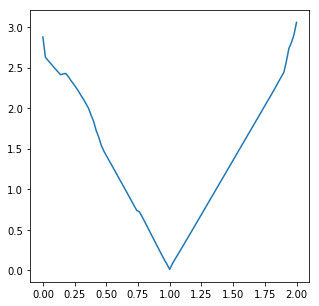

In [46]:
fig

In [47]:
fig.savefig('lossmod.png')